# Tutorial for `SCOTT`: Customizing comparison of graphs and/or graph distributions

The goal of this package is to provide a topological toolkit for comparing distributions of graphs based on their underlying curvature.

With our `Comparator` object, you will be able to input two graph distributions (or singular graphs) and run one method (namely `fit_transform`) to compute the distance between the two graph distributions.

This tutorial shepherds the user through:
1. a introduction to the Comparator object, 
2. customization options for **curvature measures** (how to calculate curvature) and **distance metrics** (how to quantify the dissimilarity between the output of curvature filtrations, i.e. persistence diagrams), and
3. benchmarking for these customization options.

## Introduction

The `Comparator` class is designed to faciliate the comparison of graph distributions with respect to their underlying curvature by computing the distance between topological descriptors of their curvature filtrations.

To demo the `Comparator` class in this notebook, we import the necessary packages and grab two dummy graphs to compare.

In [1]:
# Navigating to directory where the SCOTT repo is cloned.
import sys
# Note: You may have to change this file path.
sys.path.append("..")

# Importing from elsewhere in repo
from scott.compare import Comparator
import utils

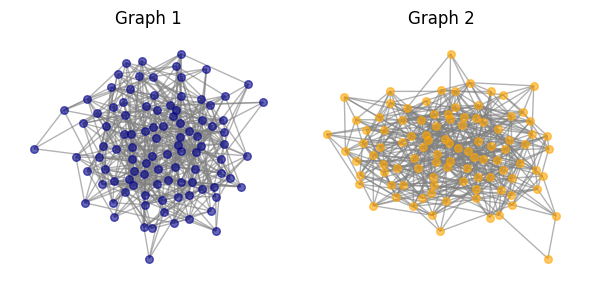

In [2]:
G1, G2 = utils.get_graphs()
utils.plot_graphs(G1, G2, "Graph 1", "Graph 2")

Finding the distance between these two graphs is as easy as initializing a Comparator instance and calling `fit_transform`.

In [3]:
# Using SCOTT to compute distance between G1 and G2

## Initialize comparator object
comp = Comparator()
## Compute distance between G1 and G2
distance_graphs = comp.fit_transform(G1, G2)
print(f"Distance between G1 and G2: {distance_graphs:.2f}")

Distance between G1 and G2: 99.50


Using the same process, we can just as easily compare distributions (lists) of graphs.

Note that the distributions do not have to be the same size, i.e. include the same number of graphs.

In [4]:
dist1, dist2 = utils.get_distributions()
print(f"Distribution 1 has {len(dist1)} graphs.")
print(f"Distribution 2 has {len(dist2)} graphs.")

Distribution 1 has 8 graphs.
Distribution 2 has 10 graphs.


We can use the same Comparator instance as before, just passing it our new graph distributions.

In [5]:
distance_dist = comp.fit_transform(dist1, dist2)
print(f"Distance between Distribution 1 and Distribution 2: {distance_dist:.2f}")

Distance between Distribution 1 and Distribution 2: 50.42


Now that you are familiar with the basic operation of the Comparator object, we introduce customization options. We will continue to use dist1 and dist2 as examples.

## Customization

How does the Comparator come up with this distance?

In brief, it does the following:  
1. **Computes curvature values for all edges of the graphs (customizable)**  
2. Executes an edge filtration based on curvature values, yielding a persistence diagram  
3. **Converts each persistence diagram into a topological descriptor (customizable)**  
4. Computes distance between topological descriptors

**Steps 1 and 3** offer room for customization. We will consider each avenue in turn.

### Customizing the curvature measures

The following methods for calculating curvature are supported:
- `"forman_curvature"` (default)
- `"balanced_forman_curvature"`
- `"ollivier_ricci_curvature"`
- `"resistance_curvature"`

The desired method is passed to the **measure** parameter when initializing the Comparator object, demonstrated below. If nothing is specified, `"forman_curvature"` is the default method.

In [6]:
# Ollivier-Ricci Curvature
orc_comp = Comparator(measure="ollivier_ricci_curvature")
orc_dist = orc_comp.fit_transform(dist1, dist2)
print(f"Distance using Ollivier-Ricci Curvature and default hyperparameters: {orc_dist:.20f}")

Distance using Ollivier-Ricci Curvature and default hyperparameters: 13.44523313137498377046


Additionally, the following attributes can be specified when initializing a `Comparator`:

- **homology_dims** : List[int]  
Dimensions of the homology groups to compute (e.g., [0, 1] for H_0 and H_1). Default is [0, 1].

- **alpha** : float, default=0.0  
Only used if Olivier-Ricci curvature is calculated, with default 0.0.  
Provides laziness parameter for default probability measure. The measure is not compatible with a user-defined **prob_fn**. If such a function is set, **alpha** will be ignored.

- **weight** : str or None, default=None  
Can be specified for (weighted) Forman-Ricci, Olivier-Ricci and Resistance curvature measures. Name of an edge attribute that is supposed to be used as an edge weight. If None, unweighted curvature is calculated. Notice that for Ollivier-Ricci curvature, if **prob_fn** is provided, this parameter will have no effect for the calculation of probability measures, but it will be used for the calculation of shortest-path distances.

- **prob_fn** : callable or None, default=None  
Used only if Ollivier-Ricci curvature is calculated, with default None. If set, should refer to a function that calculate a probability measure for a given graph and a given node. If **prob_fn** is set, providing **alpha** will not have an effect.

In [7]:
# Ollivier-Ricci Curvature with customized hyperparameters
orc_custom_comp = Comparator(measure="ollivier_ricci_curvature", homology_dims=[0], alpha=1)
orc_custom_dist = orc_custom_comp.fit_transform(dist1, dist2)
print(f"Distance using Ollivier-Ricci Curvature and homology_dims=[0], alpha = 0.8: {orc_dist:.20f}")

Distance using Ollivier-Ricci Curvature and homology_dims=[0], alpha = 0.8: 13.44523313137498377046


In [8]:
# Ollivier-Ricci Curvature with customized hyperparameter alpha
orc_custom_comp = Comparator(measure="ollivier_ricci_curvature", alpha = 0.5)
orc_custom_dist = orc_custom_comp.fit_transform(dist1, dist2)
print(f"Distance using Ollivier-Ricci Curvature and alpha = 0.8: {orc_custom_dist:.20f}")

Distance using Ollivier-Ricci Curvature and alpha = 0.8: 9.22865181627177655344


### Customizing distance metrics

Given two distributions of persistence diagrams, we support several options for measuring the distance between them:
 
1. **"landscape"**: Vectorizes persistence diagrams as persistence landscapes, computes the average landscape for each distribution, computes distance between average landscapes
2. **"image"**: Vectorizes persistence diagrams as persistence images, computes the average image for each distribution, computes distance between average images

These are specified via the `metric` parameter of a Comparator's `fit()` or `fit_transform()` method.

These metrics can be combined with any of the curvature measures above. For simplicity, we will use the default ("forman_curvature").

#### 1. Persistence landscape vectorization (default): `"landscape"`  

By default, we vectorize persistence diagrams into **persistence landscapes.**

Persistence landscapes hold the same topological information as their respective persistence diagrams, but have the additional advantage of existing in a Banach space (allowing for distance computations between vectors).

In [9]:
# Using persistence landscapes (default)
landscape_dist = comp.fit_transform(dist1, dist2, metric="landscape")
print(f"Distance between Distribution 1 and Distribution 2: {landscape_dist:.2f}")

Distance between Distribution 1 and Distribution 2: 50.42


The following additional attributes can be specified:
- **homology_dims** : List[int], default=[0, 1]  
        Dimensions of the homology groups to compute (e.g., [0, 1] for H_0 and H_1).
- **num_functions** : int, default=5  
        The number of landscape functions to compute for each homology dimension. These are usually denoted lambda_1, lambda_2, ..., lambda_{num_functions}. Recall that for each successive landscape function, the values of the highest peak function at each x-value is removed from consideration.
- **resolution** : int, default = 1000  
        Determines the number of samples for the piece-wise landscape functions (i.e. how many points are calculated).

In [10]:
# Example customization: Changing number of landscape functions
custom_landscape_dist = comp.fit_transform(dist1, dist2, metric="landscape", num_functions=6)
print(f"Distance between Distribution 1 and Distribution 2: {landscape_dist:.2f}")

# Note, in this case, the distance between the two distributions is the same as in the default case (the 6th persistence landscape contributed nothing).

Distance between Distribution 1 and Distribution 2: 50.42


#### 2. Persistence image vectorization: `"image"`  

We can also vectorize persistence diagrams into **persistence images.**

Similarly to persistence landscapes, persistence images are stored as vectors. This allows for distance computations between persistence images, whereas persistence diagrams in their raw form are harder to compare.

In [11]:
# Using persistence images
image_dist = comp.fit_transform(dist1, dist2, metric="image")
print(f"Distance between Distribution 1 and Distribution 2: {image_dist:.2f}")

Distance between Distribution 1 and Distribution 2: 10.28


The following additional attributes can also be specified:
- `homology_dims` : List[int], default=[0, 1]  
        Dimensions of the homology groups to compute (e.g., [0, 1] for H_0 and H_1).
- `bandwidth` : double, default = 1.0  
        Controls the Gaussian kernel for the probability distribution calculated for each point on the birth/persistence diagram.
        See gudhi documentation for more information.
- `weight` : function, default = lambda x: 1  
        Defines the weight function used to compute the weighted sum of the probability distributions for each point on the bith/persistence diagram, i.e. the persistence surface.
        Default is a constant function. Other common choices are a linear function or a bump function, which put greater emphasis on points with longer persistence.
        See gudhi documentation for more information.
- `resolution` : List[int, int], default = [20,20]  
        The dimensions of the persistence image in pixels.

In [12]:
# Example customization: Changing resolution
custom_image_dist = comp.fit_transform(dist1, dist2, metric="image", resolution=[10,10])
print(f"Distance between Distribution 1 and Distribution 2: {custom_image_dist:.2f}")

Distance between Distribution 1 and Distribution 2: 4.95


**In a nutshell...**

TL;DR: 
1. Curvature measures are specified via the **measure** parameter when initializing a Comparator, and 
2. distance metrics are specified via the **metric** parameter when calling a Comparator's `fit()` or `fit_transform()` methods.

## Benchmarking

We conducted the following benchmarking, comparing a distribution of 8 graphs to a distribution of 10 graphs, each with **100 nodes per graph**.

![Benchmarking with distributions of graphs with 100 nodes.](assets/benchmarking-100-nodes.png)

**Observations**
- Forman curvature performed significantly faster than other curvature metrics.
- Ollivier Ricci curvature had moderate computation times across metrics.
- Resistance curvature was the most computationally intensive, with runtimes exceeding 5 minutes per batch.

**Equipment**

Benchmarks were conducted on a computer with the following specifications:

- **Processor**: Intel Core i5-1235U
  - Physical Cores: 10
  - Logical Cores: 12
  - Base Frequency: 1.3 GHz
  - Max Turbo Frequency: 4.4 GHz
  - Cache Sizes:
    - L2 Cache: 6.65 MB
    - L3 Cache: 12 MB
- **Memory**:
  - Total: 31.64 GB
  - Available: 17.17 GB
- **GPU**: Not detected during the test.
- **Operating System**: Windows 11 (Version: 10.0.22631)
- **Disk**: C:\ (Total: 952.6 GB, Free: 562.16 GB)

## Well Done!

This concludes the tutorial.